In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/corn-or-maize-leaf-disease-dataset/data/Common_Rust/Corn_Common_Rust (454).JPG
/kaggle/input/corn-or-maize-leaf-disease-dataset/data/Common_Rust/Corn_Common_Rust (365).JPG
/kaggle/input/corn-or-maize-leaf-disease-dataset/data/Common_Rust/Corn_Common_Rust (585).JPG
/kaggle/input/corn-or-maize-leaf-disease-dataset/data/Common_Rust/Corn_Common_Rust (1171).JPG
/kaggle/input/corn-or-maize-leaf-disease-dataset/data/Common_Rust/Corn_Common_Rust (1181).JPG
/kaggle/input/corn-or-maize-leaf-disease-dataset/data/Common_Rust/Corn_Common_Rust (739).JPG
/kaggle/input/corn-or-maize-leaf-disease-dataset/data/Common_Rust/Corn_Common_Rust (1151).JPG
/kaggle/input/corn-or-maize-leaf-disease-dataset/data/Common_Rust/Corn_Common_Rust (399).JPG
/kaggle/input/corn-or-maize-leaf-disease-dataset/data/Common_Rust/Corn_Common_Rust (914).JPG
/kaggle/input/corn-or-maize-leaf-disease-dataset/data/Common_Rust/Corn_Common_Rust (283).JPG
/kaggle/input/corn-or-maize-leaf-disease-dataset/data/Common_Rust/C

# Importing Libraries and Modules

In [2]:
# import library dan modul
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [3]:
# Ukuran dimensi gambar
IMAGE_SIZE = (256,256)
# Jumlah sampel yang akan diproses dalam satu iterasi
BATCH_SIZE = 32

# Importing Images

In [4]:
# Import dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/input/corn-or-maize-leaf-disease-dataset/data",
    shuffle=True,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

Found 4188 files belonging to 4 classes.


In [5]:
# Mengecek kelas di dalam dataset
class_names = dataset.class_names
class_names

['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']

In [6]:
# Jumlah sample dataset
len(dataset)

131

In [7]:
# Mengecek jumlah data dari setiap kelas
path = '/kaggle/input/corn-or-maize-leaf-disease-dataset'

names = []
nums = []
data = {'Name of class':[],'Number of samples':[]}

for i in os.listdir(path+'/data'):
    nums.append(len(os.listdir(path+'/data/'+i)))
    names.append(i)

data['Name of class']+=names
data['Number of samples']+=nums

df = pd.DataFrame(data)
df

Name of class  Number of samples
0     Common_Rust               1306
1          Blight               1146
2         Healthy               1162
3  Gray_Leaf_Spot                574

<AxesSubplot:xlabel='Name of class', ylabel='Number of samples'>

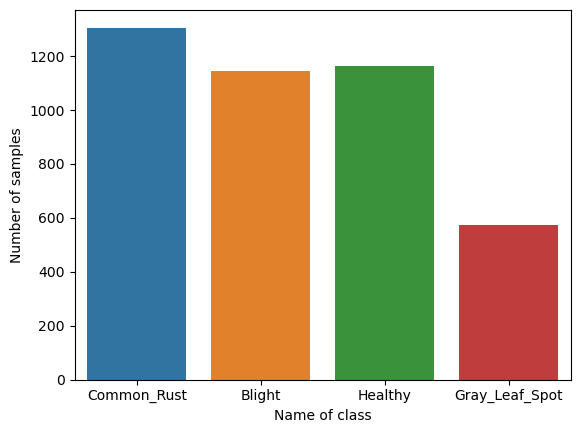

In [8]:
# Visualisasi jumlah da
sns.barplot(x=df['Name of class'],y=df['Number of samples'])

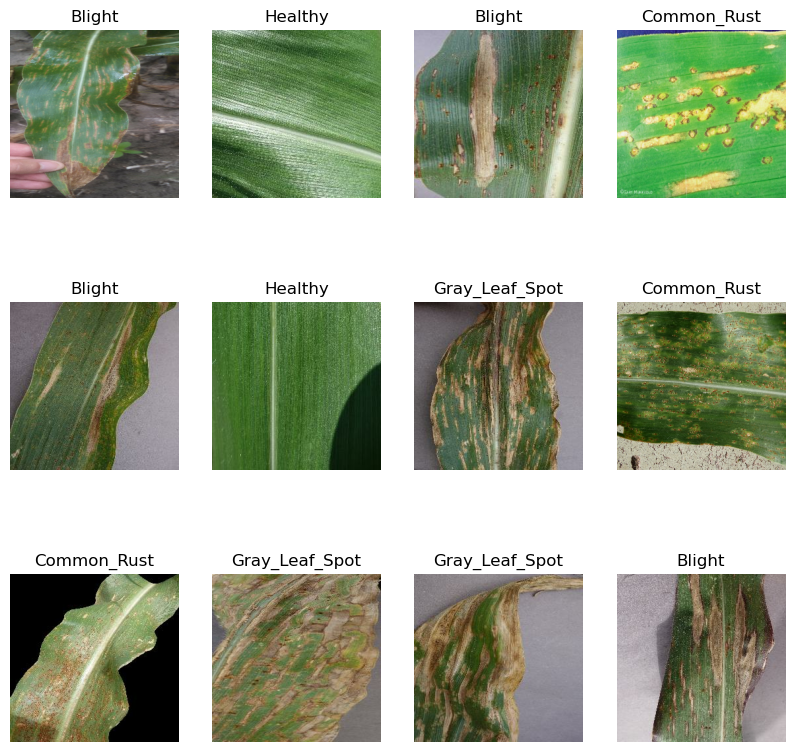

In [9]:
# Menampilkan subplot gambar dari batch pertama dataset dengan ukuran gambar 10x10 inch
plt.figure(figsize=(10,10))
for image_batch , label_batch in dataset.take(1):
    # 12 gambar dengan 3 baris dan 4 kolom
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

# Data Agumentation (Preprocessing)

In [10]:
# Membuat fungsi dengan membagi data menjadi data train 80%, validasi 10%, dan test 10% secara acak
def get_dataset(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size,seed=8)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size) 
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds,val_ds,test_ds

In [11]:
# Memanggil output dari fungsi untuk memproses dataset
train_ds,val_ds,test_ds = get_dataset(dataset)

In [12]:
# Mencetak panjang (jumlah) data
print("Jumlah data training : ",len(train_ds))
print("\nJumlah data validasi : ",len(val_ds))
print("\nJumlah data testing  : ",len(test_ds))

Jumlah data training :  104

Jumlah data validasi :  13

Jumlah data testing  :  14


In [13]:
# Menambahkan operasi catching, pengacakan, dan prefetch kedalam subset dataset
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [14]:
# Mengubah ukuran dan skala gambar
resize_and_rescale = tf.keras.Sequential([
layers.experimental.preprocessing.Resizing(256,256),
layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [15]:
# Membalik dan memutar gambar
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

# Model Building

In [22]:
# Membuat model XCeption
from tensorflow.keras.applications import Xception
from tensorflow.keras import regularizers

n_classes = 4
input_shape = (BATCH_SIZE, 256, 256, 3)

base_model = Xception(include_top=False, input_shape=(256, 256, 3), weights='imagenet')

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.5),
    layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape=input_shape)

In [23]:
# Menampilkan informasi model
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 xception (Functional)       (None, 8, 8, 2048)        20861480  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_2 (Dropout)         (None, 2048)              0         
                                                                 
 dense_3 (Dense)             (None, 64)                131136    
                                                      

In [24]:
# Konfigurasi model
model.compile(
optimizer='adam',
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
metrics=['accuracy']
)

# Model Fitting

In [25]:
checkpoint_path = "/kaggle/working/model_checkpoint.h5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)

In [26]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True
)

In [27]:
# Model training
history = model.fit(
train_ds,
epochs=50,
batch_size=BATCH_SIZE,
verbose=1,
validation_data=val_ds,
callbacks=[checkpoint,early_stopping])

Epoch 1/50
104/104 [==============================] - ETA: 0s - loss: 1.6946 - accuracy: 0.7684
Epoch 1: val_accuracy improved from -inf to 0.83654, saving model to /kaggle/working/model_checkpoint.h5
104/104 [==============================] - 73s 426ms/step - loss: 1.6946 - accuracy: 0.7684 - val_loss: 1.5436 - val_accuracy: 0.8365
Epoch 2/50
104/104 [==============================] - ETA: 0s - loss: 0.7515 - accuracy: 0.8902
Epoch 2: val_accuracy improved from 0.83654 to 0.86298, saving model to /kaggle/working/model_checkpoint.h5
104/104 [==============================] - 43s 416ms/step - loss: 0.7515 - accuracy: 0.8902 - val_loss: 0.8913 - val_accuracy: 0.8630
Epoch 3/50
104/104 [==============================] - ETA: 0s - loss: 0.5115 - accuracy: 0.9164
Epoch 3: val_accuracy did not improve from 0.86298
104/104 [==============================] - 43s 411ms/step - loss: 0.5115 - accuracy: 0.9164 - val_loss: 2.1312 - val_accuracy: 0.6490
Epoch 4/50
104/104 [==========================

In [28]:
# Mengevaluasi data test
scores = model.evaluate(test_ds)

14/14 [==============================] - 13s 100ms/step - loss: 0.1153 - accuracy: 0.9799


In [29]:
history

In [30]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 104}

In [31]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

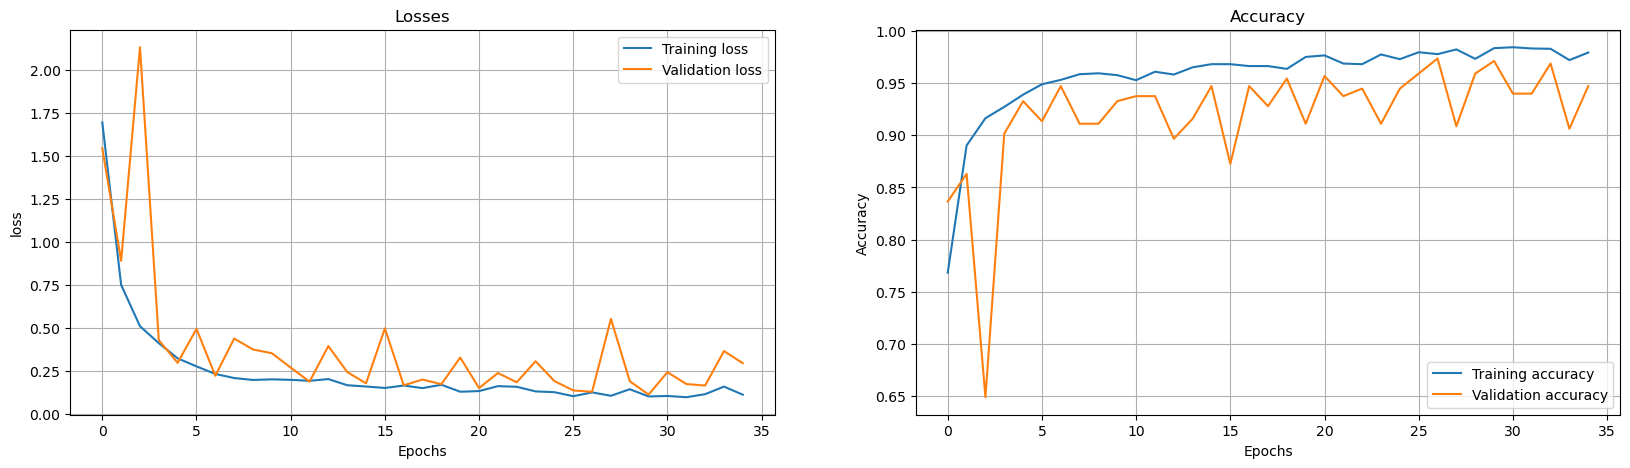

In [32]:
# Membuat grafik loss dan accuracy
his_data = pd.DataFrame(history.history)
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.plot(his_data.loss, label="Training loss")
plt.plot(his_data.val_loss, label="Validation loss")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.title("Losses")
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(his_data.accuracy, label="Training accuracy")
plt.plot(his_data.val_accuracy, label="Validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.grid()
plt.legend()

# Prediction

First Image to Predict :

Actual label: Gray_Leaf_Spot
1/1 [==============================] - 1s 939ms/step

Predicted label Blight


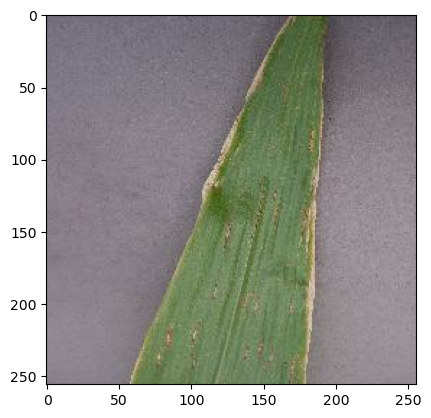

In [33]:
# Memprediksi label dari gambar pertama dalam batch data uji/test
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    print("First Image to Predict :")
    plt.imshow(first_image)
    print("\nActual label:",class_names[first_label])
    batch_prediction = model. predict (images_batch) 
    print("\nPredicted label" ,class_names[np.argmax(batch_prediction[0])])

In [34]:
# Fungsi untuk memprediksi gambar yang akan diinputkan
def predict(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    predictions = model.predict (img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
#     confidence = round(np.max(predictions[0]),2)
    confidence = round(100*(np.max(predictions[0])),2)

    return predicted_class, confidence

1/1 [==============================] - 0s 24ms/step


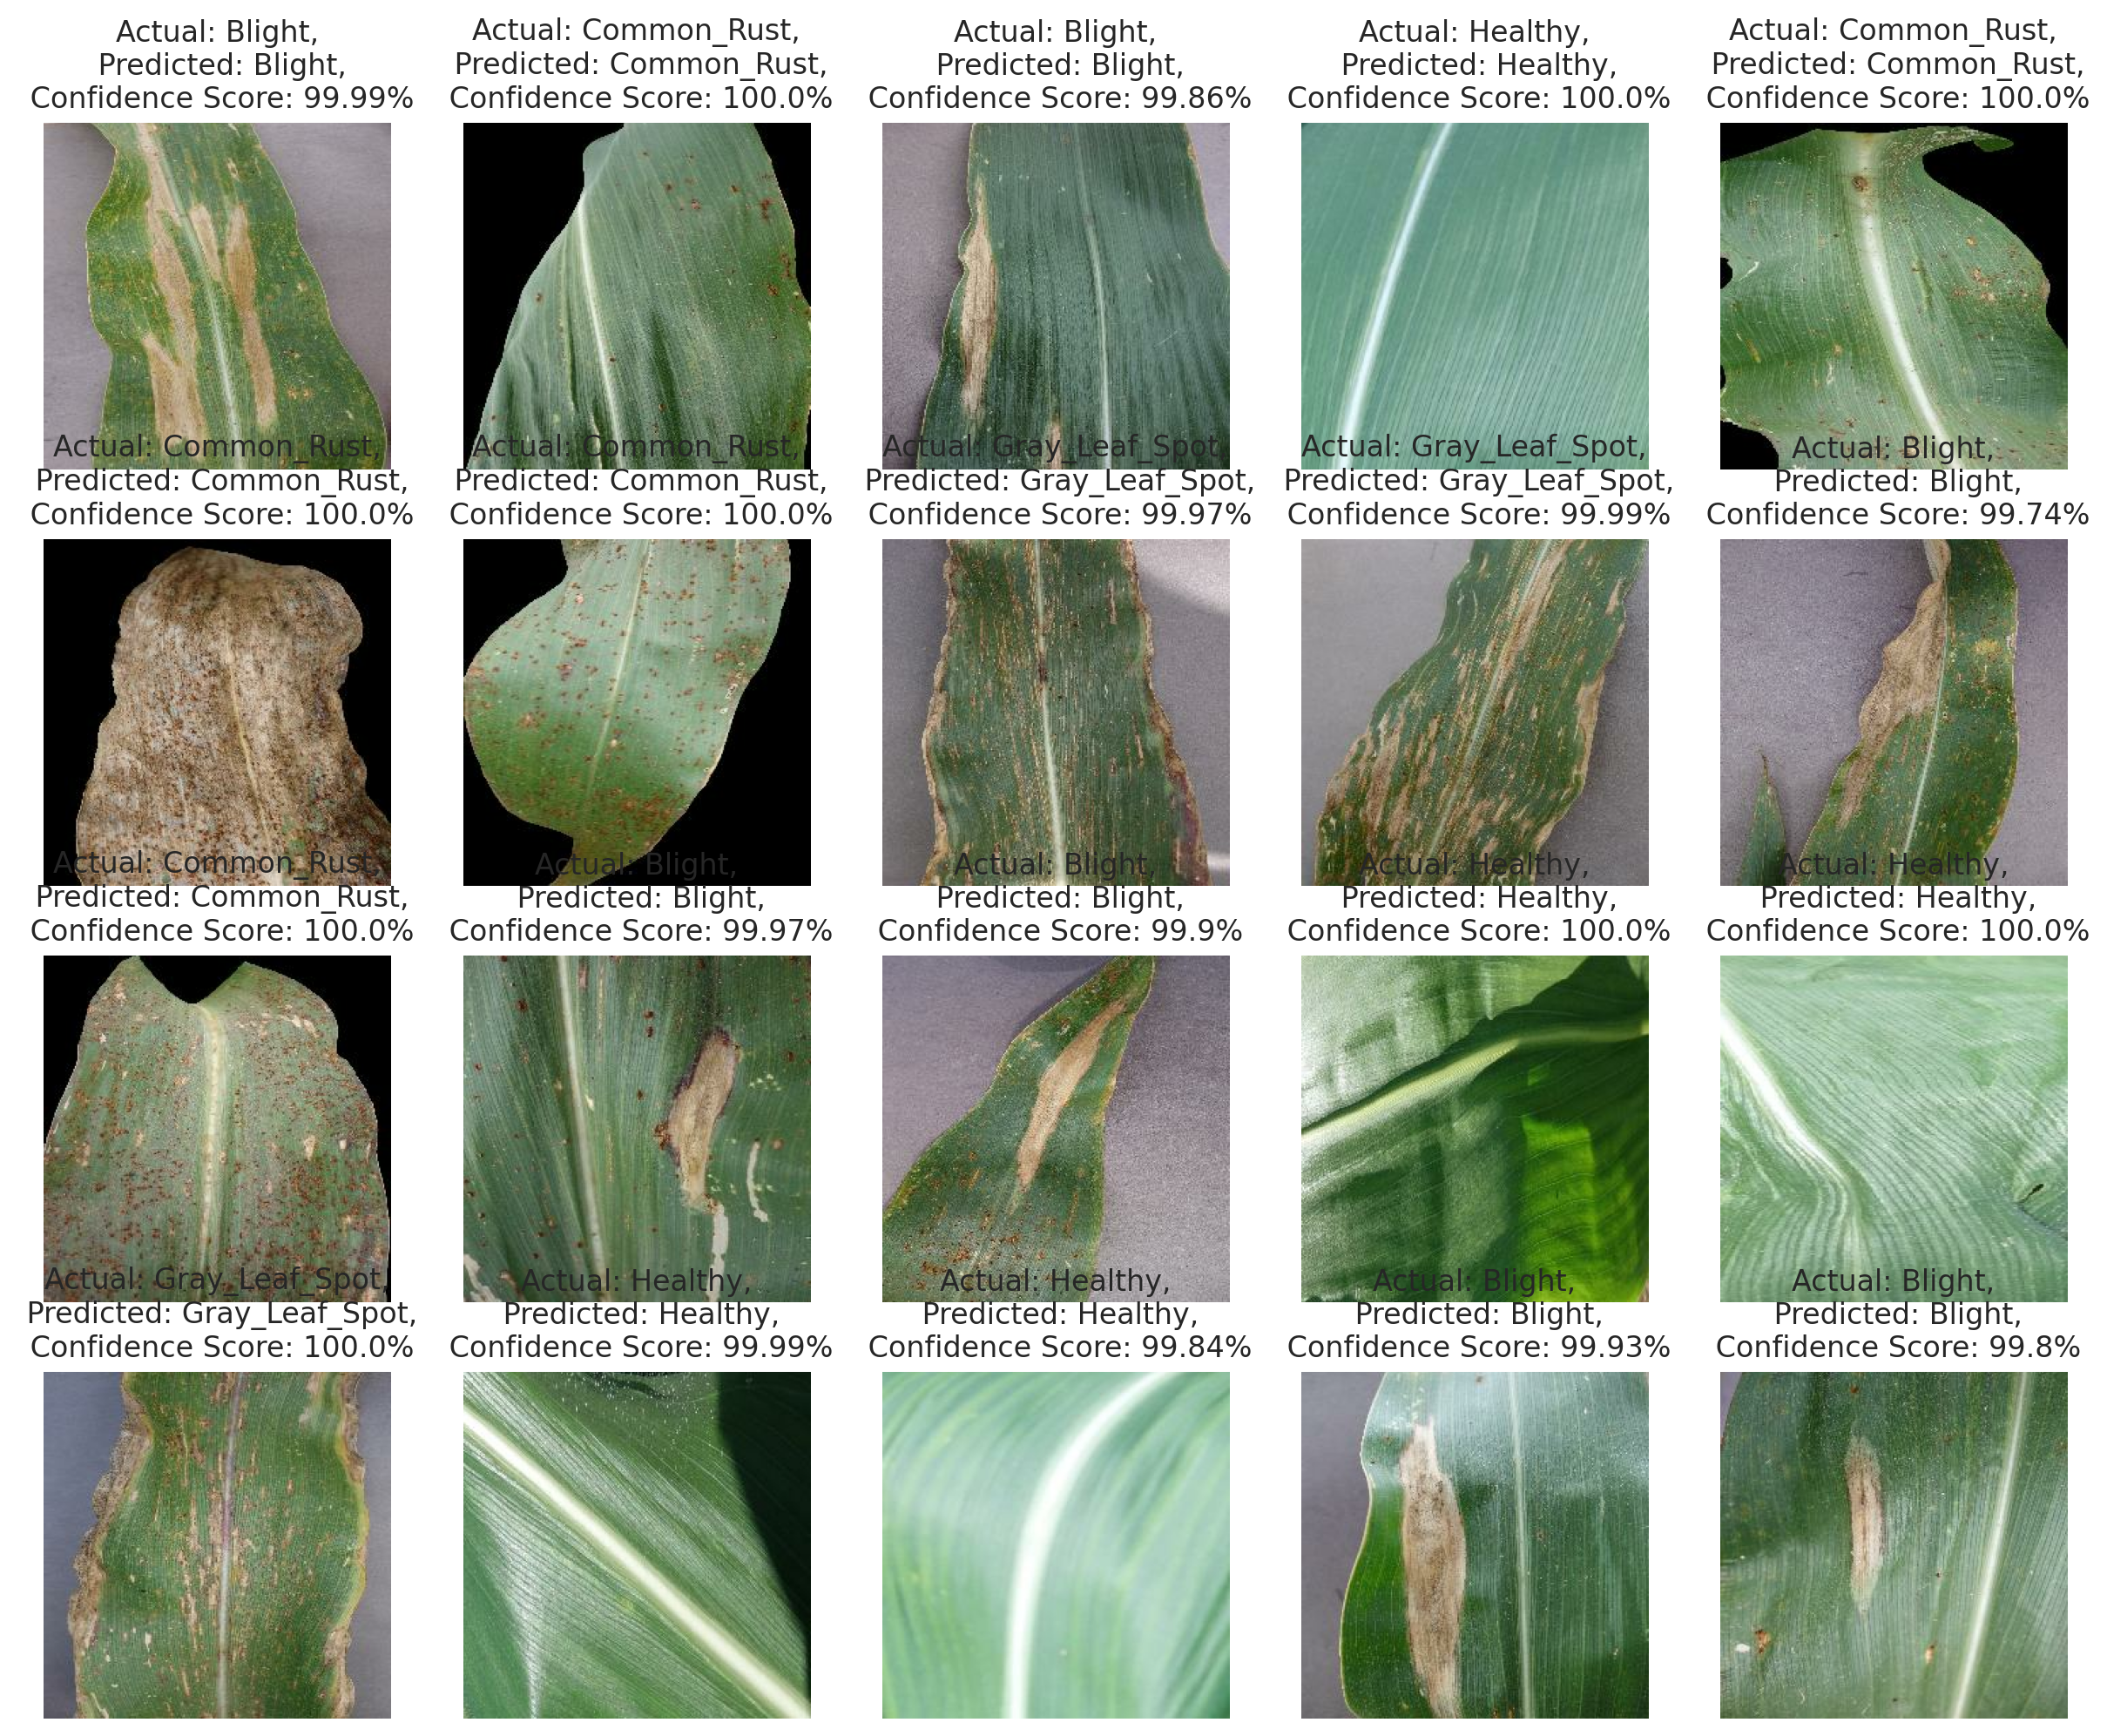

In [40]:
# Menampilkan hasil prediksi
plt.figure(figsize=(15,15))

y_pred = []
y_actual = []

for images,labels in test_ds.take(1):
    for i in range(20):
        ax = plt.subplot(5,5,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class , confidence = predict(model,images[i].numpy())
        actual_class = class_names[labels[i]]
        
        y_pred.append(predicted_class)
        y_actual.append(actual_class)
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class},\n Confidence Score: {confidence}%" )
        plt.axis("off")

# Model Evaluation

In [41]:
from sklearn.metrics import classification_report

# Matriks evaluasi
print("Classification Report:")
print(classification_report(y_actual, y_pred))

Classification Report:
                precision    recall  f1-score   support

        Blight       1.00      1.00      1.00         7
   Common_Rust       1.00      1.00      1.00         5
Gray_Leaf_Spot       1.00      1.00      1.00         3
       Healthy       1.00      1.00      1.00         5

      accuracy                           1.00        20
     macro avg       1.00      1.00      1.00        20
  weighted avg       1.00      1.00      1.00        20



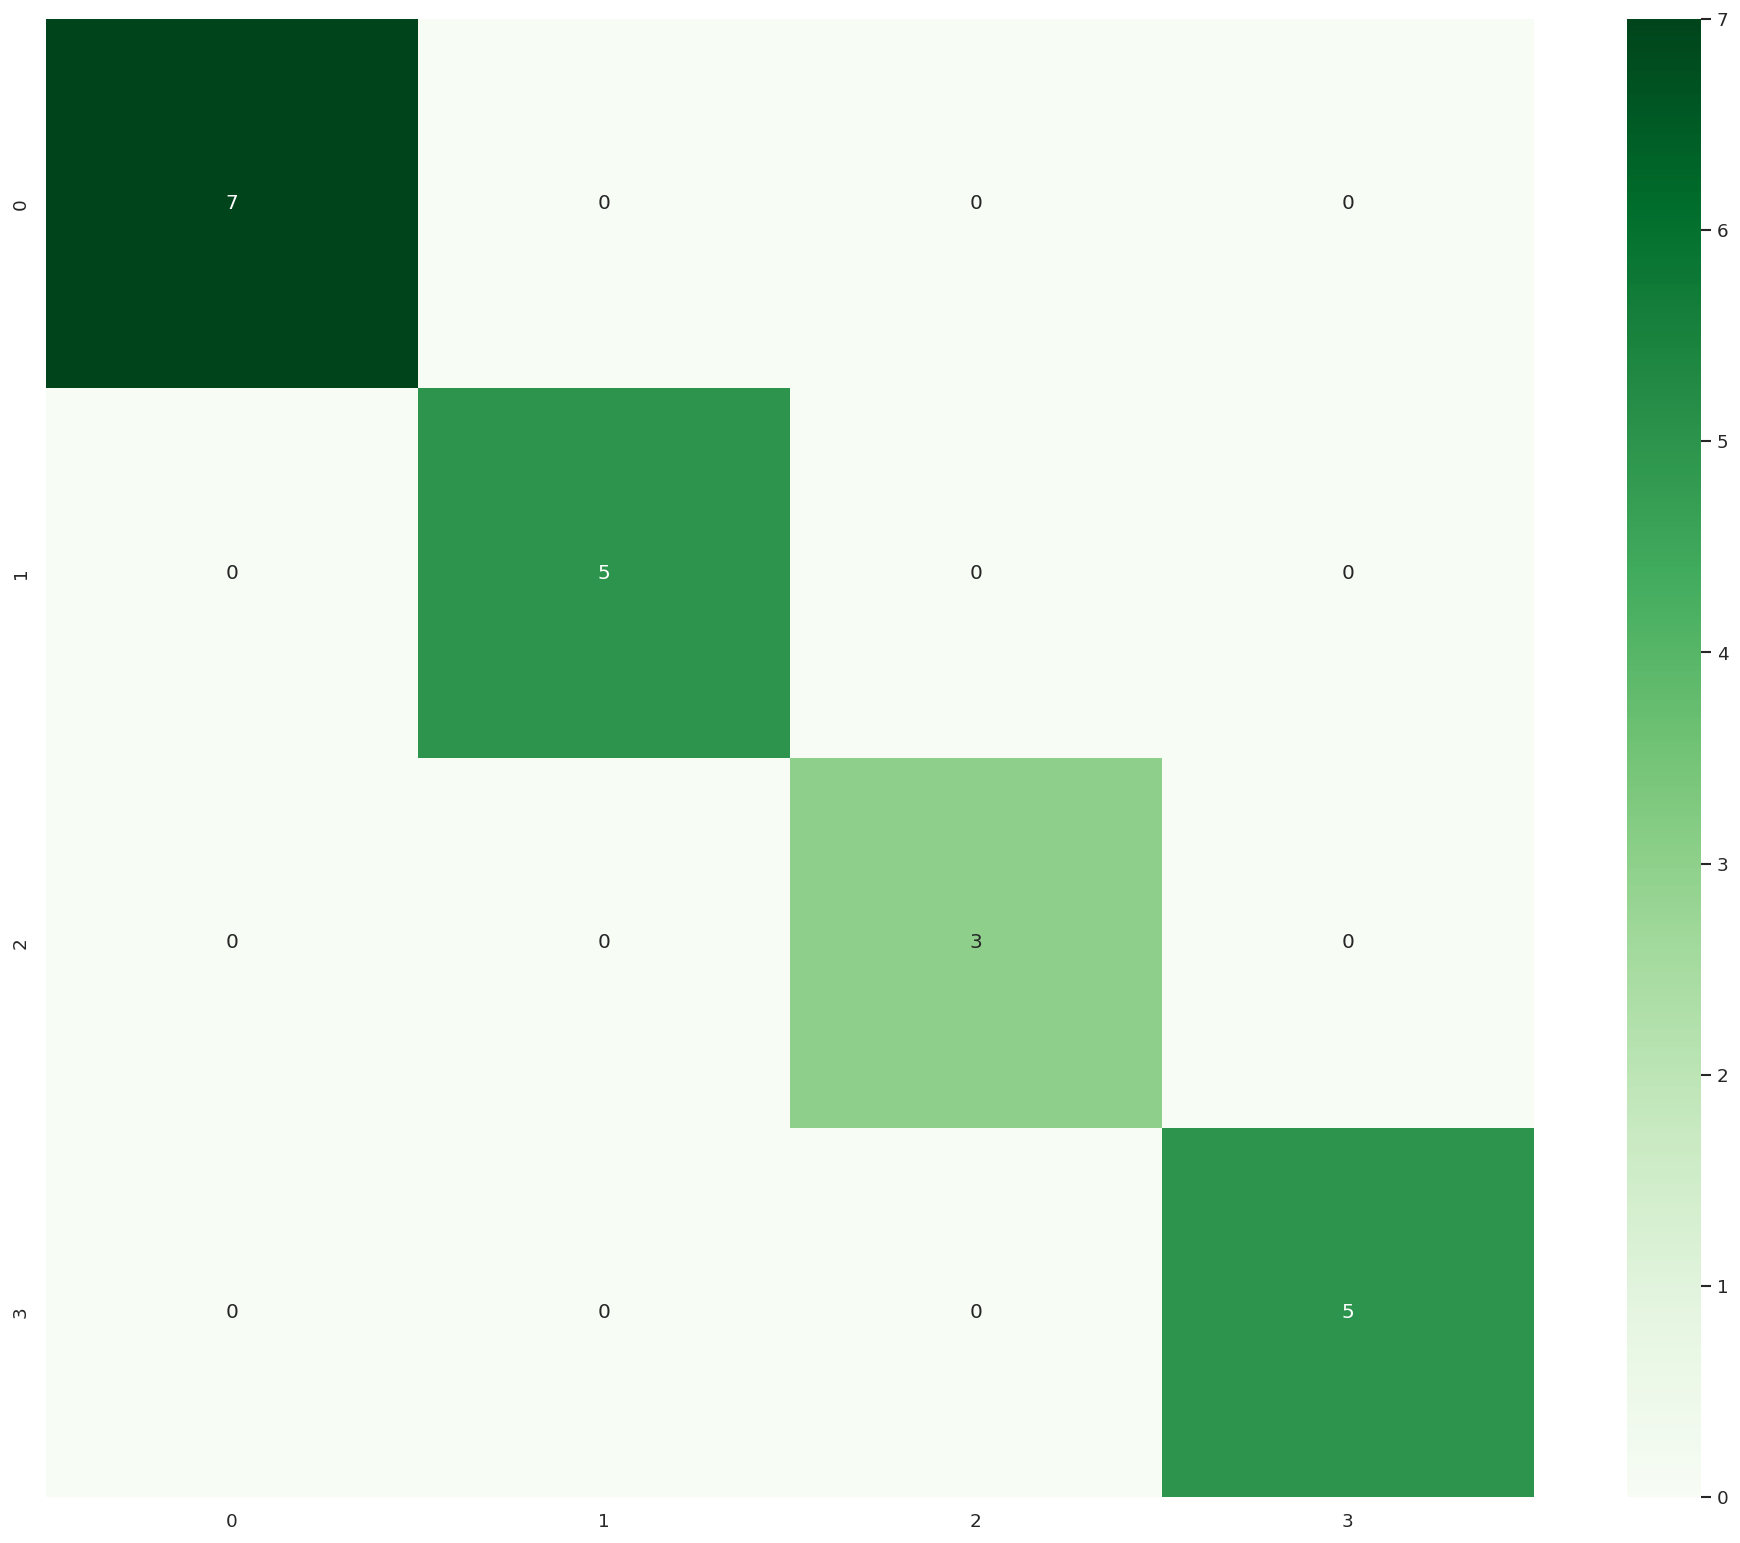

In [42]:
%config InlineBackend.figure_format ='retina'
import seaborn as sns
from sklearn.metrics import confusion_matrix
sns.set()
plt.figure(figsize=(20, 16), dpi=60)
C2= confusion_matrix(y_actual, y_pred)
sns.heatmap(C2,annot=True,cmap="Greens",fmt='.20g')
plt.savefig('heatmap.jpg')

In [43]:
# Menyimpan model dengan bobot
model.save_weights('model_weights.h5')

In [44]:
# model_version = 1
model.save('/kaggle/working/model.h5')